### **Load Libraries/Packages**

In [ ]:
# Load Libraries

# Data Handling and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam, SGD


# Date/Time operations
import datetime

# Other useful libraries
import os
import random
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")
import itertools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Download & Pre-processing**

In [ ]:
# Load the dataset
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Google_Stock_Price_Train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Google_Stock_Price_Test.csv")

# Display the first few rows
print(df_train.head(10))
print(df_test.head(10))

        Date    Open    High     Low   Close      Volume
0   1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1   1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2   1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3   1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4   1/9/2012  322.04  322.29  309.46  620.76  11,688,800
5  1/10/2012  313.70  315.72  307.30  621.43   8,824,000
6  1/11/2012  310.59  313.52  309.40  624.25   4,817,800
7  1/12/2012  314.43  315.26  312.08  627.92   3,764,400
8  1/13/2012  311.96  312.30  309.37  623.28   4,631,800
9  1/17/2012  314.81  314.81  311.67  626.86   3,832,800
        Date    Open    High     Low   Close     Volume
0   1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1   1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2   1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3   1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4   1/9/2017  806.40  809.97  802.83  806.65  1,272,400
5  1/10/2017  807.86  809.13  803.51 

In [ ]:
# Check for missing values and handle them (we will use forward fill here)
print("Training Set -- Missing values before cleaning: \n", df_train.isnull().sum())
df_train.fillna(method='ffill', inplace=True)  # Forward fill missing values
# Check again for missing values
print("Missing values after cleaning: \n", df_train.isnull().sum())


print("Testing Set -- Missing values before cleaning: \n", df_test.isnull().sum())
df_test.fillna(method='ffill', inplace=True)
print("Missing values after cleaning: \n", df_test.isnull().sum())

Training Set -- Missing values before cleaning: 
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Missing values after cleaning: 
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Testing Set -- Missing values before cleaning: 
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Missing values after cleaning: 
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# Statistical summary of the dataset
print(f"Training Statistical Summary: \n", df_train.describe())
print("\n")
print(f"Testing Statistical Summary: \n", df_test.describe())

Training Statistical Summary: 
               Open         High          Low
count  1258.000000  1258.000000  1258.000000
mean    533.709833   537.880223   529.007409
std     151.904442   153.008811   150.552807
min     279.120000   281.210000   277.220000
25%     404.115000   406.765000   401.765000
50%     537.470000   540.750000   532.990000
75%     654.922500   662.587500   644.800000
max     816.680000   816.680000   805.140000


Testing Statistical Summary: 
              Open        High         Low       Close
count   20.000000   20.000000   20.000000   20.000000
mean   807.526000  811.926500  801.949500  807.904500
std     15.125428   14.381198   13.278607   13.210088
min    778.810000  789.630000  775.800000  786.140000
25%    802.965000  806.735000  797.427500  802.282500
50%    806.995000  808.640000  801.530000  806.110000
75%    809.560000  817.097500  804.477500  810.760000
max    837.810000  841.950000  827.010000  835.670000


In [ ]:
# Check the time range of the training set
train_start_date = df_train['Date'].iloc[0]
train_end_date = df_train['Date'].iloc[-1]
print(f"Training set time range: {train_start_date} to {train_end_date}")

test_start_date = df_test['Date'].iloc[0]
test_end_date = df_test['Date'].iloc[-1]
print(f"Testing set time range: {test_start_date} to {test_end_date}")

Training set time range: 1/3/2012 to 12/30/2016
Testing set time range: 1/3/2017 to 1/31/2017


In [ ]:
# Step 3: Convert 'Volume' column to numeric (remove commas and convert to float)
## Convert 'Date' column to datetime type for better handling
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])
for col in ['Volume', 'Open', 'High', 'Low', 'Close']:
    df_train[col] = df_train[col].astype(str).str.replace(',', '').astype(float)
    df_test[col] = df_test[col].astype(str).str.replace(',', '').astype(float)

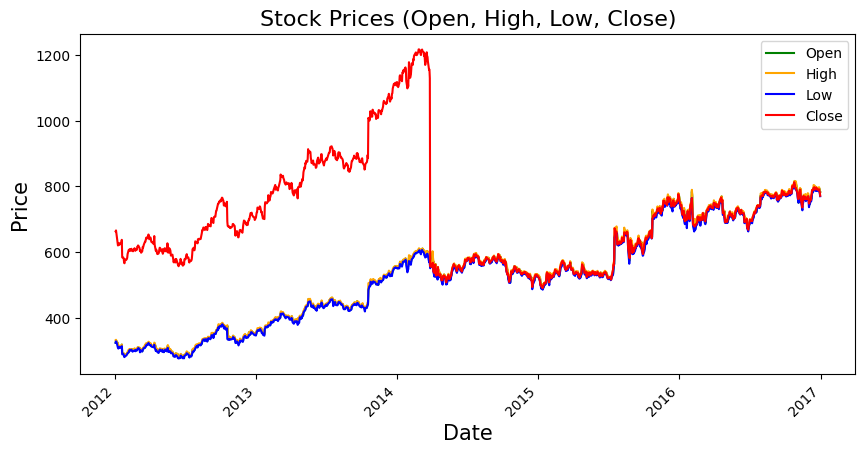

In [ ]:
# before the Close price adjustment
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_train['Date'], df_train['Open'], label='Open', color='green')
ax.plot(df_train['Date'], df_train['High'], label='High', color='orange')
ax.plot(df_train['Date'], df_train['Low'], label='Low', color='blue')
ax.plot(df_train['Date'], df_train['Close'], label='Close', color='red')
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Price', size=15)
ax.set_title("Stock Prices (Open, High, Low, Close)", fontsize=16)
ax.legend()
fig.autofmt_xdate(rotation=45)
fig.show()

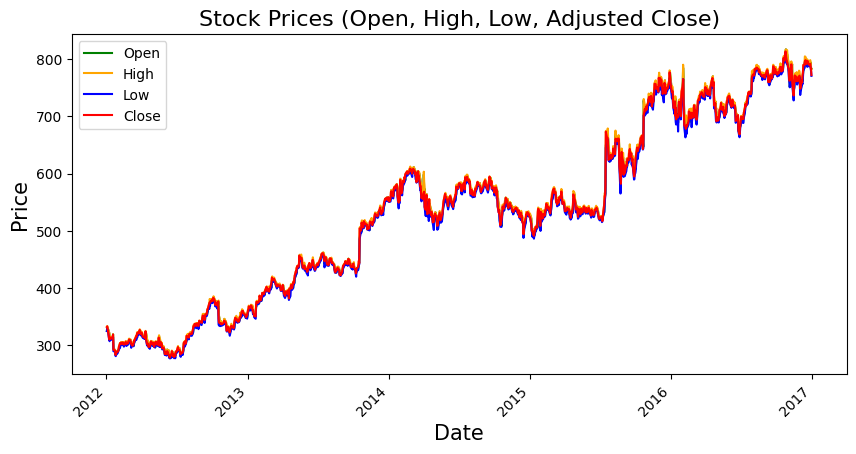

In [ ]:
# Adjust 'Close' prices
df_train['Close'] = df_train.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_train['Date'], df_train['Open'], label='Open', color='green')
ax.plot(df_train['Date'], df_train['High'], label='High', color='orange')
ax.plot(df_train['Date'], df_train['Low'], label='Low', color='blue')
ax.plot(df_train['Date'], df_train['Close'], label='Close', color='red')
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Price', size=15)
ax.set_title("Stock Prices (Open, High, Low, Adjusted Close)", fontsize=16)
ax.legend()
fig.autofmt_xdate(rotation=45)
fig.show()

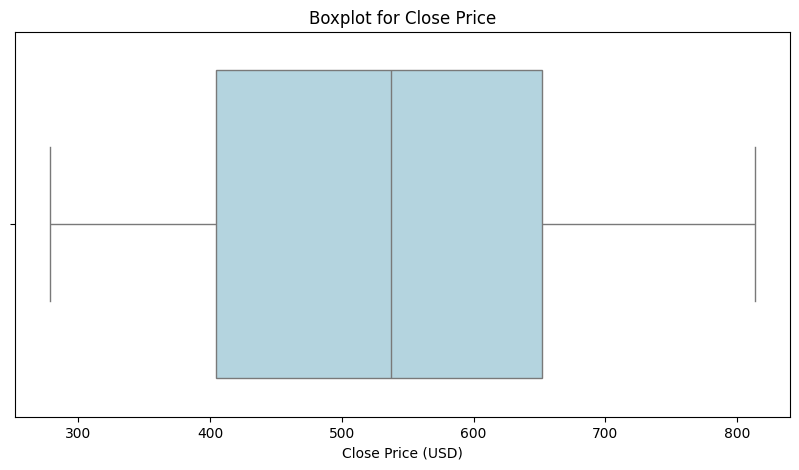

In [ ]:
#  boxplot for 'Close' prices
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['Close'], color='lightblue')

plt.title("Boxplot for Close Price")
plt.xlabel("Close Price (USD)")
plt.show()

In [ ]:
from re import I
# Calculate Q1, Q3, and IQR for 'Close' price
Q1 = df_train['Close'].quantile(0.25)
Q3 = df_train['Close'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers based on IQR
outliers_iqr = df_train[(df_train['Close'] < lower_bound) | (df_train['Close'] > upper_bound)]

print(f"Outliers based on IQR:\n{outliers_iqr[['Date', 'Close']]}")

Outliers based on IQR:
Empty DataFrame
Columns: [Date, Close]
Index: []


In [ ]:
# Step 5: Feature Engineering - Normalization
# We'll normalize the features using MinMaxScaler to bring the values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize Input Features and Target
scaler = MinMaxScaler(feature_range=(0, 1))
df_train[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(
    df_train[['Open', 'High', 'Low', 'Close', 'Volume']])
df_test[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.transform(
    df_test[['Open', 'High', 'Low', 'Close', 'Volume']])



In [ ]:
# Step 6: Feature Engineering - Create Lag Features
# We will create lag features, meaning that we'll use the past 30 days to predict the next day's price.
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i]['Close'])  # Target is next day's closing price
    return np.array(X), np.array(y)

# Create dataset with lag of 10 days, testing set only has 20 entries, so lag needs to < 20
# window_size = min(30, len(test_scaled))
window_size = 10
X_train, y_train = create_dataset(df_train[['Open', 'High', 'Low', 'Close', 'Volume']], window_size)
X_test, y_test = create_dataset(df_test[['Open', 'High', 'Low', 'Close', 'Volume']], window_size)

print(f"Shape of Train X: {X_train.shape}, Shape of Train y: {y_train.shape}")
print(f"Shape of Test X :{X_test.shape}, Shape of Test y: {y_test.shape}")

Shape of Train X: (1248, 10, 5), Shape of Train y: (1248,)
Shape of Test X :(10, 10, 5), Shape of Test y: (10,)


In [ ]:
# Step 7: Split Training Set into Training and Validation Sets (80-20 Split)
train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size

X_train, X_val = X_train[:train_size], X_train[train_size:]
y_train, y_val = y_train[:train_size], y_train[train_size:]


In [ ]:
# Step 6: Create PyTorch Datasets for Training, Validation, and Testing
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [ ]:
# Step 8: Create DataLoaders for Training, Validation, and Testing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")

Training Dataset Size: 998
Validation Dataset Size: 250
Testing Dataset Size: 10


In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

def move_to_device(data, device):
    if isinstance(data, torch.Tensor):
        return data.to(device)
    return torch.tensor(data, dtype=torch.float32).to(device)


#### **Training Loop**

In [ ]:
# Define a function for training and validation
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device):
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return train_loss / len(train_loader), val_loss / len(val_loader)

#### **Evaluating Loop**

In [ ]:
# Define a function for evaluating the model on test data
def evaluate_model(model, val_loader, criterion, device='cpu'):
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = move_to_device(inputs, device), move_to_device(targets, device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

            val_predictions.append(outputs.cpu().numpy())
            val_targets.append(targets.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_predictions = np.concatenate(val_predictions, axis=0)
    val_targets = np.concatenate(val_targets, axis=0)

    mse, rmse, mae = calculate_metrics(val_targets, val_predictions)
    return avg_val_loss, mse, rmse, mae



### **Model Architectures**

#### **Vanilla RNN**

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.0):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size

        # Add dropout to the RNN layer
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          batch_first=True, dropout=dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize the hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Pass the input through the RNN layer
        out, _ = self.rnn(x, h0)

        # Pass the output of the last timestep through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out


#### **GRU**

In [ ]:
class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUNetwork, self).__init__()
        self.hidden_size = hidden_size

        # Define the GRU layer
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Pass input through the GRU layer
        out, _ = self.gru(x, h0)

        # Use the output of the last timestep
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, bidirectional=False):
        super(GRUNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the GRU layer
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)

        # Fully connected output layer with dropout
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Ensure x is a PyTorch tensor and move it to the correct device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)

        device = next(self.parameters()).device
        x = x.to(device)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers * (2 if self.gru.bidirectional else 1), x.size(0), self.hidden_size).to(device)

        # Pass input through the GRU layer
        out, _ = self.gru(x, h0)

        # Use the output of the last timestep
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out



#### **LSTM**

In [ ]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, dropout=0.0, bidirectional=True):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size,
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)

        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_size * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.layer_size * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Pass the input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Use the output of the last timestep and pass through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out


In [143]:
# Hyperparameter search space
param_grid = {
    'lr': [0.001, 0.005, 0.01],
    'hidden_size': [32, 64, 128],
    'batch_size': [32, 64],
    'num_layers': [1, 2],
    'dropout': [0, 0.2, 0.5],
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad'],
    'bidirectional': [True, False], }


def hyperparameter_search(X_train, y_train, X_val, y_val, device, model_type="RNN"):
    best_model = None
    best_mae = float('inf')
    best_params = None

    # Generate all combinations of hyperparameters
    for params in itertools.product(*param_grid.values()):
        lr, hidden_size, batch_size, num_layers, dropout, optimizer_name, bidirectional = params

        # Select the model based on the model_type
        if model_type == "RNN":
            model = VanillaRNN(input_size=X_train.shape[2], hidden_size=hidden_size, output_size=1, dropout=dropout)
        elif model_type == "GRU":
            model = GRUNetwork(input_size=X_train.shape[2], hidden_size=hidden_size, output_size=1, dropout=dropout)
        elif model_type == "LSTM":
            model = LSTMNetwork(input_size=X_train.shape[2], hidden_size=hidden_size, layer_size=num_layers, output_size=1, dropout=dropout, bidirectional=bidirectional)

        # model.to(device)

        # optimizer
        if optimizer_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif optimizer_name == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "adagrad":
            optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

        criterion = nn.MSELoss()

        # Train the model and validate using train and validation sets only
        train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device)

        # Evaluate the model on validation set
        val_mae, val_rmse, val_r2 = evaluate_model(model, val_loader, device)

        if val_mae < best_mae:
            best_mae = val_mae
            best_model = model
            best_params = params

        print(f"Params: {params}, Validation MAE: {val_mae}, Validation RMSE: {val_rmse}, Validation R²: {val_r2}")

    return best_model, best_params


In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_GRU, best_params_GRU = hyperparameter_search(X_train, y_train, X_val, y_val, device, model_type="GRU")

print(f"Best Hyperparameters for GRU model: {best_params_GRU}")

Params: (0.001, 32, 32, 1, 0, 'adam', True), Validation MAE: 0.32623547315597534, Validation RMSE: 0.3304522633552551, Validation R²: -25.15874481201172
Params: (0.001, 32, 32, 1, 0, 'adam', False), Validation MAE: 0.25129106640815735, Validation RMSE: 0.2556845545768738, Validation R²: -14.660600662231445
Params: (0.001, 32, 32, 1, 0, 'sgd', True), Validation MAE: 0.542835533618927, Validation RMSE: 0.5466625094413757, Validation R²: -70.587646484375
Params: (0.001, 32, 32, 1, 0, 'sgd', False), Validation MAE: 0.5632578134536743, Validation RMSE: 0.566646933555603, Validation R²: -75.91738891601562
Params: (0.001, 32, 32, 1, 0, 'rmsprop', True), Validation MAE: 0.4567696452140808, Validation RMSE: 0.4610782861709595, Validation R²: -49.92708206176758
Params: (0.001, 32, 32, 1, 0, 'rmsprop', False), Validation MAE: 0.4258553087711334, Validation RMSE: 0.43017467856407166, Validation R²: -43.32912063598633
Params: (0.001, 32, 32, 1, 0, 'adagrad', True), Validation MAE: 0.583644032478332

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_RNN, best_params_RNN = hyperparameter_search(X_train, y_train, X_val, y_val, device, model_type="RNN")

print(f"Best Hyperparameters for Vanilla RNN model: {best_params_RNN}")

Params: (0.001, 32, 32, 1, 0, 'adam', True), Validation MAE: 0.4581121802330017, Validation RMSE: 0.46203529834747314, Validation R²: -50.13870620727539
Params: (0.001, 32, 32, 1, 0, 'adam', False), Validation MAE: 0.38521671295166016, Validation RMSE: 0.3888597786426544, Validation R²: -35.223087310791016
Params: (0.001, 32, 32, 1, 0, 'sgd', True), Validation MAE: 0.4954829812049866, Validation RMSE: 0.49954453110694885, Validation R²: -58.778892517089844
Params: (0.001, 32, 32, 1, 0, 'sgd', False), Validation MAE: 0.4187792241573334, Validation RMSE: 0.4229602813720703, Validation R²: -41.85471725463867
Params: (0.001, 32, 32, 1, 0, 'rmsprop', True), Validation MAE: 0.32858747243881226, Validation RMSE: 0.3337725102901459, Validation R²: -25.68705177307129
Params: (0.001, 32, 32, 1, 0, 'rmsprop', False), Validation MAE: 0.4985218644142151, Validation RMSE: 0.5026153326034546, Validation R²: -59.51609420776367
Params: (0.001, 32, 32, 1, 0, 'adagrad', True), Validation MAE: 0.875267684

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_LSTM, best_params_LSTM = hyperparameter_search(X_train, y_train, X_val, y_val, device, model_type="LSTM")

print(f"Best Hyperparameters for LSTM model: {best_params_LSTM}")

Params: (0.001, 32, 32, 1, 0, 'adam', True), Validation MAE: 0.2861645519733429, Validation RMSE: 0.290004163980484, Validation R²: -19.146886825561523
Params: (0.001, 32, 32, 1, 0, 'adam', False), Validation MAE: 0.41413065791130066, Validation RMSE: 0.4172326326370239, Validation R²: -40.7019157409668
Params: (0.001, 32, 32, 1, 0, 'sgd', True), Validation MAE: 0.6338399648666382, Validation RMSE: 0.6371350884437561, Validation R²: -96.24392700195312
Params: (0.001, 32, 32, 1, 0, 'sgd', False), Validation MAE: 0.6768404245376587, Validation RMSE: 0.6798034310340881, Validation R²: -109.70472717285156
Params: (0.001, 32, 32, 1, 0, 'rmsprop', True), Validation MAE: 0.4725039005279541, Validation RMSE: 0.4764889180660248, Validation R²: -53.388248443603516
Params: (0.001, 32, 32, 1, 0, 'rmsprop', False), Validation MAE: 0.3999738395214081, Validation RMSE: 0.4043545126914978, Validation R²: -38.16733932495117
Params: (0.001, 32, 32, 1, 0, 'adagrad', True), Validation MAE: 0.6130206584930

#### **Model Comparison and Selection**

In [154]:
# Function to evaluate model performance using MAE, RMSE, and R²
def evaluate_model(model, val_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    # Convert to numpy arrays for easier evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return mae, rmse, r2

# Evaluate the best models (RNN, GRU, LSTM) using validation data
models = {
    "RNN": best_RNN,
    "GRU": best_GRU,
    "LSTM": best_LSTM}


performance_metrics = {}

# Evaluate each model on validation set
for model_name, model in models.items():
    mae, rmse, r2 = evaluate_model(model, val_loader, device)
    performance_metrics[model_name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Choose the best model based on performance (lowest MAE, RMSE, highest R²)
best_model_name = min(performance_metrics, key=lambda x: performance_metrics[x]["MAE"])

print(f"\nBest Model Based on Validation Set: {best_model_name}")


RNN - MAE: 0.0808, RMSE: 0.0933, R²: -1.0870
GRU - MAE: 0.0378, RMSE: 0.0450, R²: 0.5142
LSTM - MAE: 0.1744, RMSE: 0.1791, R²: -6.6879

Best Model Based on Validation Set: GRU


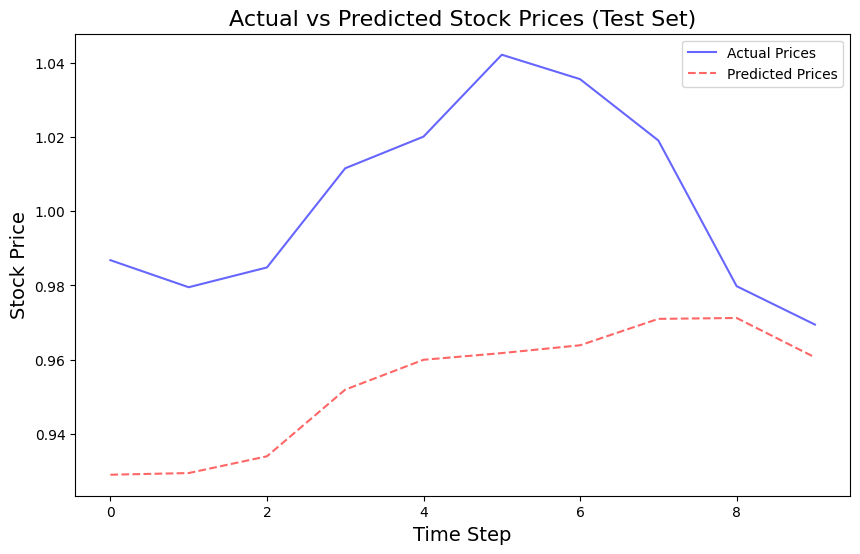

Test Set Evaluation for GRU Model:
MAE: 0.0496, RMSE: 0.0545, R²: -3.9254


In [156]:
def evaluate_and_predict(model, test_loader, device):
    model.eval()

    actuals, predictions = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Append the actual values and predictions to the respective lists
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    actual_values = np.array(actuals)
    predicted_values = np.array(predictions)

    # Calculate performance metrics
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    r2 = r2_score(actual_values, predicted_values)

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='Actual Prices', color='blue', alpha=0.6)
    plt.plot(predicted_values, label='Predicted Prices', color='red', linestyle='--', alpha=0.6)
    plt.title('Actual vs Predicted Stock Prices (Test Set)', fontsize=16)
    plt.xlabel('Time Step', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend()
    plt.show()

    return mae, rmse, r2


best_model = best_GRU

test_mae, test_rmse, test_r2 = evaluate_and_predict(best_model, test_loader, device)

print(f"Test Set Evaluation for GRU Model:")
print(f"MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

